<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

<b>Описание проекта</b>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

<b>Цель проекта</b>

Обучить модель и классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

<b>Задачи проекта</b>

Построить модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. [Загрузите и подготовьте данные.](#step_1)
2. [Обучите разные модели.](#step_2)
3. [Сделайте выводы.](#step_3)

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<a id="step_1"></a>
## Подготовка

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import re
import tqdm
from tqdm.notebook import tqdm
import nltk
import en_core_web_sm
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

Загрузим наш файл

In [2]:
try:
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

Напишем функцию для просмотра наших данных

In [3]:
def first_look (df: pd.DataFrame, limit_na_category: int = 10) -> None:
    '''Функция получения первичной информации о датафрейме'''
    print ('------------- Первые 5 строк ------------')
    display(df.head())
    print('')
    print('')
    print ('------------- Типы данных ------------')
    print (df.info())
    print('')
    print('')
    print ('------------- Пропуски ------------')
    count = 0
    shape_0 = df.shape[0]
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков, ', round(df[element].isna().sum() * 100 / shape_0,2),\
                  '% от числа строк.' )
            count = +1
    if count == 0:
        print('Пропусков НЕТ')
        print('')
        print('')
    print ('------------- Дубликаты ------------')
    if df.duplicated().sum() > 0:
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
    # ищем, есть ли категориальные столбцы (содержащие до limit_na_category уникальных значений) в датафрейме
    min_unique = limit_na_category + 1
    for element in df._get_numeric_data().columns:
        min_unique = min(min_unique, df[element].nunique())
        if min_unique <= limit_na_category:
            print('')
    print('')
    print('------------- Категориальные признаки ------------')
    for element in df._get_numeric_data().columns:
        if df[element].nunique() <= limit_na_category:
            print(element, ': ', df[element].nunique(), 'категории - ', df[element].unique(), )

Взглянем на наши данные

In [4]:
first_look(df)

------------- Первые 5 строк ------------


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


------------- Пропуски ------------
Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов НЕТ


------------- Категориальные признаки ------------
toxic :  2 категории -  [0 1]


Наши данные состоят из двух столбцов. Столбкец 'text' содержит текст комментария, а столбец 'toxic' - целевой признак

Посмотрим на распределение целевого признака

<AxesSubplot:>

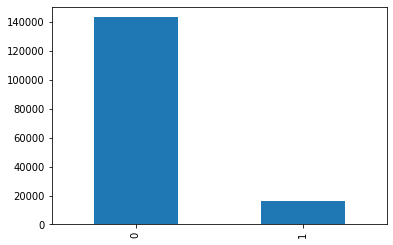

In [5]:
df['toxic'].value_counts().plot(kind='bar')

Наблюдаем явный дисбаланс классов

Нам необходимо ощистить текст от нежелательных символом и лемматизировать его

Функция очистки текста от нежелательных символов

In [6]:
def clear_text(text):
    
    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z ]', ' ', text).strip()
    
    # Удаляем html теги
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Удаляем единичные символы
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Удаляем единычные символы из начала строки
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
    
    # Заменяем несколько пробелов на один
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Удаляем 'b'
    text = re.sub(r'^b\s+', '', text)
        
    return text

Очистим текст от нежелательных символов

In [7]:
df['text'] = df['text'].apply(clear_text)
display(df.head())

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour m seem...,0
2,hey man m really not trying to edit war it jus...,0
3,more can make any real suggestions on improvem...,0
4,you sir are my hero any chance you remember wh...,0


Для токенизации и лемматизации воспользуемся моделью en_core_web_sm, т.к. ни pymystem3 ни WordNetLemmatizer не дали результата из-за постоянного падения ядра системы (не могу сказать с чем это связано, но 3 дня меня убили...)

In [8]:
nlp = en_core_web_sm.load()

def lemmatize(text):
    temp = []
    for i in nlp(text):
        if i.is_stop == False:
            temp.append(i.lemma_)
    return " ".join(temp)


tqdm.pandas()
df['text'] = df['text'].progress_apply(lemmatize)

  0%|          | 0/159571 [00:00<?, ?it/s]

In [9]:
df.head()

,text,toxic
0,explanation edit username hardcore metallica f...,0
1,d aww match background colour m seemingly stic...,0
2,hey man m try edit war guy constantly remove r...,0
3,real suggestion improvement wonder section sta...,0
4,sir hero chance remember page,0


Сохраним наши данные для последующего пропуска шага лемматизации

In [10]:
dump(df, 'toxic_comments_lemmas.csv')

['toxic_comments_lemmas.csv']

Загрузим наши данные сохраненные после лемматизации

In [11]:
df = load('toxic_comments_lemmas.csv')

На данном шаге мы просмотрели наши данные, очистили их и лемматизировали.

Обучим наши модели на подготовленных данных

<a id="step_2"></a>
## Обучение

Разобьем наши данные на обучающую и тестовую выборки в соотношении 75:25

In [12]:
features = df['text']
target = df['toxic']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Создадим признаки с учетом стоп-слов и выделим целевые признаки

In [13]:
# Загрузим стоп-слова
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

# Создадим счетчик, указав в нем стоп-слова
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
# Посчитаем TD-IDF для корпуса текстов
tf_idf = count_tf_idf.fit(features_train)
# Создадим признаки
features_train = tf_idf.transform(features_train)
features_test = tf_idf.transform(features_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ded_mopo3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Функция обучения наших моделей, поиска наилучшей метрики f1 и подобранных параметров

In [14]:
def model_look (model, parameters, features, target):
    model_grid = GridSearchCV(model, parameters, cv=5, scoring='f1', verbose=5)
    model_grid.fit(features, target)
    return model_grid.best_score_, model_grid.best_params_

Обучим модель логистической регресии

In [21]:
parameters = {'C': range(23, 26, 1), 'max_iter': range(8, 10, 1)}
f1, best_parameters = model_look (LogisticRegression(random_state=12345, solver='liblinear'), parameters, features_train, target_train)
display('Лучшие параметры модели линейной регрессии:', best_parameters)
display('Дали f1 модели:', f1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ..................C=23, max_iter=8;, score=0.766 total time=   1.3s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ..................C=23, max_iter=8;, score=0.767 total time=   1.2s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..................C=23, max_iter=8;, score=0.774 total time=   1.2s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..................C=23, max_iter=8;, score=0.774 total time=   1.3s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..................C=23, max_iter=8;, score=0.786 total time=   1.2s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ..................C=23, max_iter=9;, score=0.762 total time=   1.5s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ..................C=23, max_iter=9;, score=0.764 total time=   1.5s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..................C=23, max_iter=9;, score=0.769 total time=   1.5s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..................C=23, max_iter=9;, score=0.775 total time=   1.5s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..................C=23, max_iter=9;, score=0.779 total time=   1.5s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ..................C=24, max_iter=8;, score=0.766 total time=   1.2s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ..................C=24, max_iter=8;, score=0.767 total time=   1.2s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..................C=24, max_iter=8;, score=0.774 total time=   1.2s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..................C=24, max_iter=8;, score=0.774 total time=   1.3s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..................C=24, max_iter=8;, score=0.786 total time=   1.3s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ..................C=24, max_iter=9;, score=0.762 total time=   1.5s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ..................C=24, max_iter=9;, score=0.764 total time=   1.5s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..................C=24, max_iter=9;, score=0.769 total time=   1.5s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..................C=24, max_iter=9;, score=0.774 total time=   1.6s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..................C=24, max_iter=9;, score=0.780 total time=   1.5s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ..................C=25, max_iter=8;, score=0.766 total time=   1.3s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ..................C=25, max_iter=8;, score=0.766 total time=   1.2s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..................C=25, max_iter=8;, score=0.773 total time=   1.3s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..................C=25, max_iter=8;, score=0.774 total time=   1.2s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..................C=25, max_iter=8;, score=0.786 total time=   1.2s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ..................C=25, max_iter=9;, score=0.763 total time=   1.5s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ..................C=25, max_iter=9;, score=0.764 total time=   1.6s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..................C=25, max_iter=9;, score=0.769 total time=   1.5s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..................C=25, max_iter=9;, score=0.774 total time=   1.5s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..................C=25, max_iter=9;, score=0.780 total time=   1.5s


/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


'Лучшие параметры модели линейной регрессии:'

{'C': 24, 'max_iter': 8}

'Дали f1 модели:'

0.7735287284102534

In [22]:
results = pd.DataFrame ({'model':['LogisticRegression'], 'best_parameters_train':[best_parameters], 'f1_train':[f1]})
results

,model,best_parameters_train,f1_train
0,LogisticRegression,"{'C': 24, 'max_iter': 8}",0.773529


Обучим модель дерева решений

In [24]:
parameters = {'max_depth': range(122, 124, 1)}
f1, best_parameters = model_look (DecisionTreeClassifier(random_state=12345), parameters, features_train, target_train)
display('Лучшие параметры модели дерева решений:', best_parameters)
display('Дали f1 модели:', f1)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .....................max_depth=123;, score=0.726 total time=  42.1s
[CV 2/5] END .....................max_depth=123;, score=0.728 total time=  42.3s
[CV 3/5] END .....................max_depth=123;, score=0.725 total time=  42.0s
[CV 4/5] END .....................max_depth=123;, score=0.739 total time=  42.3s
[CV 5/5] END .....................max_depth=123;, score=0.739 total time=  41.8s
[CV 1/5] END .....................max_depth=124;, score=0.723 total time=  42.2s
[CV 2/5] END .....................max_depth=124;, score=0.728 total time=  42.5s
[CV 3/5] END .....................max_depth=124;, score=0.729 total time=  42.3s
[CV 4/5] END .....................max_depth=124;, score=0.740 total time=  44.3s
[CV 5/5] END .....................max_depth=124;, score=0.734 total time=  43.8s
[CV 1/5] END .....................max_depth=125;, score=0.729 total time=  43.8s
[CV 2/5] END .....................max_depth=125;,

'Лучшие параметры модели дерева решений:'

{'max_depth': 123}

'Дали f1 модели:'

0.7313256315075375

In [25]:
results = results.append({'model':'DecisionTreeClassifier', 'best_parameters_train':best_parameters, 'f1_train':f1}, ignore_index=True)
results

/tmp/ipykernel_13246/1575865374.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model':'DecisionTreeClassifier', 'best_parameters_train':best_parameters, 'f1_train':f1}, ignore_index=True)


,model,best_parameters_train,f1_train
0,LogisticRegression,"{'C': 24, 'max_iter': 8}",0.773529
1,DecisionTreeClassifier,{'max_depth': 123},0.731326


Обучим модель случайного леса

In [29]:
parameters = {'max_depth': range(213, 216, 1), 'n_estimators': range(3, 6, 1)}
f1, best_parameters = model_look (RandomForestClassifier(random_state=12345), parameters, features_train, target_train)
display('Лучшие параметры модели случайного леса:', best_parameters)
display('Дали f1 модели:', f1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....max_depth=213, n_estimators=3;, score=0.569 total time=  10.1s
[CV 2/5] END .....max_depth=213, n_estimators=3;, score=0.562 total time=  10.0s
[CV 3/5] END .....max_depth=213, n_estimators=3;, score=0.565 total time=   9.9s
[CV 4/5] END .....max_depth=213, n_estimators=3;, score=0.552 total time=   9.9s
[CV 5/5] END .....max_depth=213, n_estimators=3;, score=0.605 total time=   9.8s
[CV 1/5] END .....max_depth=213, n_estimators=4;, score=0.608 total time=  13.2s
[CV 2/5] END .....max_depth=213, n_estimators=4;, score=0.613 total time=  13.3s
[CV 3/5] END .....max_depth=213, n_estimators=4;, score=0.612 total time=  13.5s
[CV 4/5] END .....max_depth=213, n_estimators=4;, score=0.617 total time=  13.4s
[CV 5/5] END .....max_depth=213, n_estimators=4;, score=0.632 total time=  13.1s
[CV 1/5] END .....max_depth=213, n_estimators=5;, score=0.563 total time=  16.5s
[CV 2/5] END .....max_depth=213, n_estimators=5;,

'Лучшие параметры модели случайного леса:'

{'max_depth': 213, 'n_estimators': 4}

'Дали f1 модели:'

0.6162375081128225

In [30]:
results = results.append({'model':'RandomForestClassifier', 'best_parameters_train':best_parameters, 'f1_train':f1}, ignore_index=True)
results

/tmp/ipykernel_13246/2498858417.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model':'RandomForestClassifier', 'best_parameters_train':best_parameters, 'f1_train':f1}, ignore_index=True)


,model,best_parameters_train,f1_train
0,LogisticRegression,"{'C': 24, 'max_iter': 8}",0.773529
1,DecisionTreeClassifier,{'max_depth': 123},0.731326
2,RandomForestClassifier,"{'max_depth': 213, 'n_estimators': 4}",0.616238


Обучим модель CatBoostClassifier

In [34]:
parameters = {'iterations': range(1000, 1200, 100)}
f1, best_parameters = model_look (CatBoostClassifier(random_state=12345), parameters, features_train, target_train)
display('Лучшие параметры модели случайного леса:', best_parameters)
display('Дали f1 модели:', f1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Learning rate set to 0.072254
0:	learn: 0.6197442	total: 282ms	remaining: 4m 41s
1:	learn: 0.5554031	total: 551ms	remaining: 4m 35s
2:	learn: 0.5046842	total: 813ms	remaining: 4m 30s
3:	learn: 0.4626274	total: 1.08s	remaining: 4m 28s
4:	learn: 0.4268768	total: 1.35s	remaining: 4m 28s
5:	learn: 0.3955297	total: 1.62s	remaining: 4m 29s
6:	learn: 0.3698600	total: 1.9s	remaining: 4m 28s
7:	learn: 0.3494874	total: 2.17s	remaining: 4m 28s
8:	learn: 0.3317181	total: 2.43s	remaining: 4m 27s
9:	learn: 0.3156122	total: 2.7s	remaining: 4m 27s
10:	learn: 0.3026872	total: 2.98s	remaining: 4m 27s
11:	learn: 0.2915877	total: 3.24s	remaining: 4m 27s
12:	learn: 0.2809265	total: 3.51s	remaining: 4m 26s
13:	learn: 0.2726291	total: 3.79s	remaining: 4m 26s
14:	learn: 0.2659040	total: 4.05s	remaining: 4m 26s
15:	learn: 0.2599101	total: 4.32s	remaining: 4m 25s
16:	learn: 0.2545312	total: 4.59s	remaining: 4m 25s
17:	learn: 0.2497326	total: 4.86s	rema

'Лучшие параметры модели случайного леса:'

{'iterations': 1000}

'Дали f1 модели:'

0.7525523177597421

In [35]:
results = results.append({'model':'CatBoostClassifier', 'best_parameters_train':best_parameters, 'f1_train':f1}, ignore_index=True)
results

/tmp/ipykernel_13246/632782783.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model':'CatBoostClassifier', 'best_parameters_train':best_parameters, 'f1_train':f1}, ignore_index=True)


,model,best_parameters_train,f1_train
0,LogisticRegression,"{'C': 24, 'max_iter': 8}",0.773529
1,DecisionTreeClassifier,{'max_depth': 123},0.731326
2,RandomForestClassifier,"{'max_depth': 213, 'n_estimators': 4}",0.616238
3,CatBoostClassifier,{'iterations': 1000},0.752552


На данном этапе мы обучили наши данные моделями машинного обучения и выявили оптимальные гиперпараметры для этих моделей. Проверим полученные значения на тестовых данных

Функция обучения моделей на тестовой выборке и занесения результата метрики f1  в таблицу

In [36]:
def ml_result(model, features_train, target_train, features_test, target_test):
        
    model.fit(features_train, target_train)
    
    predictions = model.predict(features_test)
    
    f1 = f1_score(target_test, predictions)
      
    return f1

Проверим модель логистической регрессии на тестовом наборе

In [37]:
f1 = ml_result(LogisticRegression(
    random_state=12345, solver='liblinear', C=24, max_iter=8), features_train, target_train, features_test, target_test
              )
results.loc[0, 'f1_test'] = f1
results

/home/ded_mopo3/my_projects/my_projects_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,model,best_parameters_train,f1_train,f1_test
0,LogisticRegression,"{'C': 24, 'max_iter': 8}",0.773529,0.785157
1,DecisionTreeClassifier,{'max_depth': 123},0.731326,NaN
2,RandomForestClassifier,"{'max_depth': 213, 'n_estimators': 4}",0.616238,NaN
3,CatBoostClassifier,{'iterations': 1000},0.752552,NaN


Проверим модель дерева решений на тестовом наборе

In [38]:
f1 = ml_result(DecisionTreeClassifier(
    random_state=12345, max_depth=123), features_train, target_train, features_test, target_test
              )
results.loc[1, 'f1_test'] = f1
results

,model,best_parameters_train,f1_train,f1_test
0,LogisticRegression,"{'C': 24, 'max_iter': 8}",0.773529,0.785157
1,DecisionTreeClassifier,{'max_depth': 123},0.731326,0.735248
2,RandomForestClassifier,"{'max_depth': 213, 'n_estimators': 4}",0.616238,NaN
3,CatBoostClassifier,{'iterations': 1000},0.752552,NaN


Проверим модель случайного дерева на тестовом наборе

In [39]:
f1 = ml_result(RandomForestClassifier(
    random_state=12345, max_depth=213, n_estimators=4), features_train, target_train, features_test, target_test
              )
results.loc[2, 'f1_test'] = f1
results

,model,best_parameters_train,f1_train,f1_test
0,LogisticRegression,"{'C': 24, 'max_iter': 8}",0.773529,0.785157
1,DecisionTreeClassifier,{'max_depth': 123},0.731326,0.735248
2,RandomForestClassifier,"{'max_depth': 213, 'n_estimators': 4}",0.616238,0.596819
3,CatBoostClassifier,{'iterations': 1000},0.752552,NaN


Проверим модель CatBoostClassifier на тестовом наборе

In [40]:
f1 = ml_result(CatBoostClassifier(
    random_state=12345, iterations=1000), features_train, target_train, features_test, target_test
              )
results.loc[3, 'f1_test'] = f1
results

Learning rate set to 0.079478
0:	learn: 0.6113118	total: 349ms	remaining: 5m 48s
1:	learn: 0.5440424	total: 664ms	remaining: 5m 31s
2:	learn: 0.4890391	total: 972ms	remaining: 5m 22s
3:	learn: 0.4431814	total: 1.28s	remaining: 5m 19s
4:	learn: 0.4058909	total: 1.6s	remaining: 5m 17s
5:	learn: 0.3747928	total: 1.9s	remaining: 5m 15s
6:	learn: 0.3504079	total: 2.21s	remaining: 5m 14s
7:	learn: 0.3297073	total: 2.53s	remaining: 5m 13s
8:	learn: 0.3126955	total: 2.85s	remaining: 5m 13s
9:	learn: 0.2987042	total: 3.16s	remaining: 5m 12s
10:	learn: 0.2866515	total: 3.48s	remaining: 5m 12s
11:	learn: 0.2765755	total: 3.79s	remaining: 5m 12s
12:	learn: 0.2682846	total: 4.12s	remaining: 5m 12s
13:	learn: 0.2603549	total: 4.43s	remaining: 5m 12s
14:	learn: 0.2542009	total: 4.76s	remaining: 5m 12s
15:	learn: 0.2492204	total: 5.07s	remaining: 5m 11s
16:	learn: 0.2445862	total: 5.39s	remaining: 5m 11s
17:	learn: 0.2405349	total: 5.7s	remaining: 5m 11s
18:	learn: 0.2372390	total: 6.02s	remaining: 5m

,model,best_parameters_train,f1_train,f1_test
0,LogisticRegression,"{'C': 24, 'max_iter': 8}",0.773529,0.785157
1,DecisionTreeClassifier,{'max_depth': 123},0.731326,0.735248
2,RandomForestClassifier,"{'max_depth': 213, 'n_estimators': 4}",0.616238,0.596819
3,CatBoostClassifier,{'iterations': 1000},0.752552,0.761221


На данном этапе мы обучили модели машинного обучения на тренировочной выборке и проверили их на тестовой выборке. Лучшими характеристиками и гарантированно успешно по условиям задачи себя показали модели логистической регрессии и CatBoostClassifier.

<a id="step_3"></a>
## Выводы

Согласно условиям задачи мы можем выделить две модели, которые справились с возложенными на них функциями.

Но, согласно полученных данных, рекомендовать мы будем только модель логистической регресии по двум причинам:

1. Более точное предсказание.

2. Намного меньшее время как обучения, так и предсказаний.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны